# Examen Segundo Interciclo — Cuaderno 1  
**Tema:** Clasificación de imágenes (vaca / cerdo / gallina)  
**Autores:** (Zahid Armijos y Cristopher Jara) — **Usuario GitHub:** criss16-nimoi  
**Fecha:** (11/02/2025)

> Este cuaderno contiene: preparación del dataset, entrenamiento base y registro de experimentos en **MLflow**.


## Objetivo
Entrenar un modelo de clasificación de imágenes con 3 clases (**vaca**, **cerdo**, **gallina**) y registrar cada entrenamiento en **MLflow** para trazabilidad y comparación.


In [4]:
from pathlib import Path
import random
import shutil
import numpy as np
import pandas as pd

from PIL import Image
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# -------------------------
# 0) CONFIG
# -------------------------
SEED = 7
random.seed(SEED)
np.random.seed(SEED)

# Clases CANÓNICAS (las usaremos en CSVs y entrenamiento)
CLASSES = ["vaca", "cerdo", "gallina"]

# Tus carpetas reales (con mayúsculas) dentro de raw/
# Si tus nombres cambian, ajusta aquí.
CLASS_DIRNAME = {
    "vaca": "Vaca",
    "cerdo": "Cerdo",
    "gallina": "Gallina",
}

IMG_EXTS = {".jpg", ".jpeg", ".png", ".webp", ".bmp", ".tif", ".tiff"}

MAX_PER_CLASS = 50      # tu caso: 50 por especie
MIN_W, MIN_H = 50, 50   # filtro mínimo por seguridad (puedes subirlo si quieres)

# -------------------------
# 1) RUTAS DEL PROYECTO
# -------------------------
PROJECT_DIR = Path().resolve()

DATASET_ROOT = PROJECT_DIR / "Dataset Animales"
RAW_DIR      = DATASET_ROOT / "raw"

DATA_DIR     = DATASET_ROOT / "dataset_v1"   # salida final (train/val/test)
META_DIR     = DATASET_ROOT / "meta"         # CSVs de splits

TEST_DIR     = PROJECT_DIR / "test_images"

def ensure_dirs():
    for p in [DATASET_ROOT, RAW_DIR, META_DIR, TEST_DIR]:
        p.mkdir(parents=True, exist_ok=True)

def list_images(folder: Path):
    if not folder.exists():
        return []
    files = []
    for p in folder.rglob("*"):
        if p.is_file() and p.suffix.lower() in IMG_EXTS:
            files.append(p)
    return sorted(files, key=lambda x: str(x).lower())

def get_size_safe(path: Path):
    try:
        with Image.open(path) as im:
            return im.size  # (w,h)
    except Exception:
        return None

ensure_dirs()

print("PROJECT_DIR:", PROJECT_DIR)
print("RAW_DIR:", RAW_DIR)
print("TEST_DIR:", TEST_DIR)


PROJECT_DIR: C:\Users\leoos\Examen_Segundo_Interciclo
RAW_DIR: C:\Users\leoos\Examen_Segundo_Interciclo\Dataset Animales\raw
TEST_DIR: C:\Users\leoos\Examen_Segundo_Interciclo\test_images


In [5]:
# -------------------------
# 2) VERIFICAR RAW: conteo por clase + chequeos
# -------------------------
rows = []
for c in CLASSES:
    d = RAW_DIR / CLASS_DIRNAME[c]
    imgs = list_images(d)
    rows.append({"class": c, "folder": str(d), "n_images": len(imgs)})

df_count = pd.DataFrame(rows)
display(df_count)

# Validación rápida
missing = df_count[df_count["n_images"] == 0]
if len(missing) > 0:
    raise FileNotFoundError(
        "Hay clases sin imágenes o carpetas mal nombradas:\n" + missing.to_string(index=False)
    )

print("\n OK: se encontraron imágenes en todas las clases.")


,class,folder,n_images
0,vaca,C:\Users\leoos\Examen_Segundo_Interciclo\Datas...,51
1,cerdo,C:\Users\leoos\Examen_Segundo_Interciclo\Datas...,52
2,gallina,C:\Users\leoos\Examen_Segundo_Interciclo\Datas...,52



 OK: se encontraron imágenes en todas las clases.


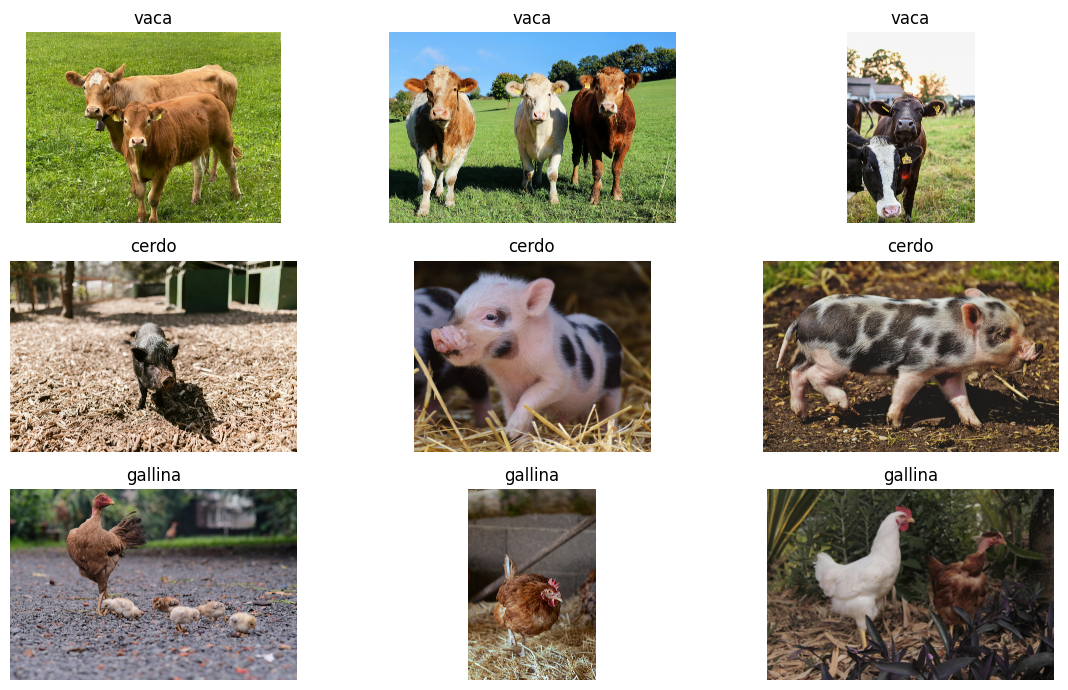

w                                                             \
        count         mean          std     min      25%     50%     75%   
class                                                                      
cerdo    52.0  4697.134615  1599.745801  2268.0  3635.25  4035.5  6000.0   
gallina  52.0  4418.134615  1397.163696  1715.0  3357.25  4384.0  5637.5   
vaca     51.0  4541.117647  1582.923645  1024.0  3531.50  4032.0  5999.0   

                    h                                                     \
            max count         mean          std     min      25%     50%   
class                                                                      
cerdo    8192.0  52.0  3977.173077  1312.686270  1880.0  2911.00  4000.0   
gallina  8192.0  52.0  4185.826923  1058.797685  1728.0  3566.25  3999.5   
vaca     8192.0  51.0  4176.215686  1362.677032   682.0  3281.00  4024.0   

                          
             75%     max  
class                     
cerdo    5096.25  7008.0  
gallina  4817.00  6240.0  
vaca     5297.50  8056.0

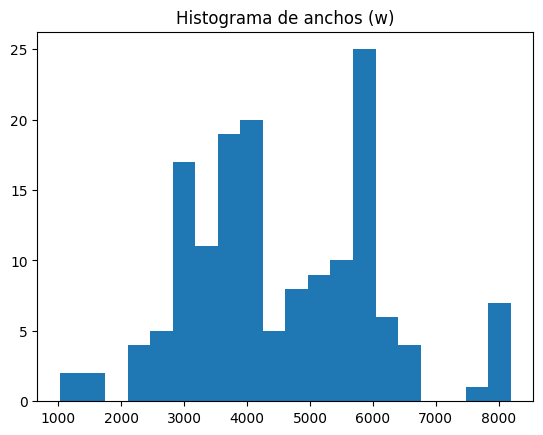

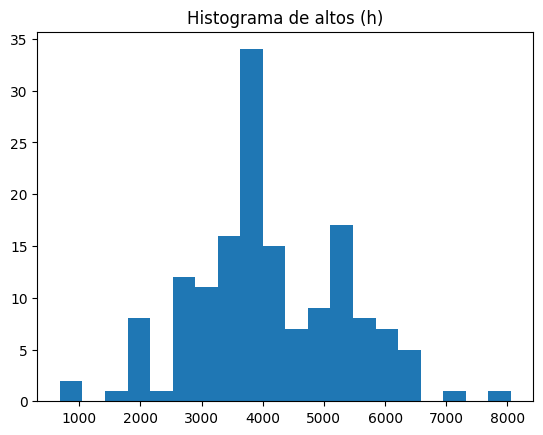

In [6]:
# -------------------------
# 3) EDA RÁPIDO: mostrar muestras + tamaños
# -------------------------
def show_samples_per_class(n=3):
    plt.figure(figsize=(12, 7))
    k = 1
    for c in CLASSES:
        d = RAW_DIR / CLASS_DIRNAME[c]
        imgs = list_images(d)
        pick = random.sample(imgs, k=min(n, len(imgs)))
        for p in pick:
            with Image.open(p) as im:
                ax = plt.subplot(len(CLASSES), n, k)
                ax.imshow(im.convert("RGB"))
                ax.set_title(c)
                ax.axis("off")
            k += 1
    plt.tight_layout()
    plt.show()

show_samples_per_class(n=3)

# Tamaños (w,h)
sizes = []
for c in CLASSES:
    d = RAW_DIR / CLASS_DIRNAME[c]
    imgs = list_images(d)
    for p in imgs:
        sz = get_size_safe(p)
        if sz is None:
            continue
        w, h = sz
        sizes.append({"class": c, "w": w, "h": h, "path": str(p)})

df_sizes = pd.DataFrame(sizes)
display(df_sizes.groupby("class")[["w","h"]].describe())

plt.figure()
plt.hist(df_sizes["w"], bins=20)
plt.title("Histograma de anchos (w)")
plt.show()

plt.figure()
plt.hist(df_sizes["h"], bins=20)
plt.title("Histograma de altos (h)")
plt.show()


In [7]:
# -------------------------
# 4) ARMAR ÍNDICE (filtrado + limitar a 50 por clase)
# -------------------------
records = []

for c in CLASSES:
    d = RAW_DIR / CLASS_DIRNAME[c]
    imgs = list_images(d)

    # Filtrar por tamaño mínimo
    good = []
    for p in imgs:
        sz = get_size_safe(p)
        if sz is None:
            continue
        w, h = sz
        if (w >= MIN_W) and (h >= MIN_H):
            good.append(p)

    # Limitar a MAX_PER_CLASS (si hay más)
    random.shuffle(good)
    good = good[:MAX_PER_CLASS]

    for p in good:
        records.append({"path": str(p), "class": c})

df = pd.DataFrame(records)

print("Total imágenes consideradas:", len(df))
display(df.groupby("class").size())

if df.groupby("class").size().min() == 0:
    raise RuntimeError("Alguna clase quedó vacía tras el filtrado. Baja MIN_W/MIN_H o revisa imágenes.")


Total imágenes consideradas: 150


class
cerdo      50
gallina    50
vaca       50
dtype: int64

In [8]:
# -------------------------
# 5) CREAR dataset_v1 con split 70/15/15 (estratificado)
#    (igual a tu cuaderno original)
# -------------------------
RESET_DATA_DIR = True  # si True: borra dataset_v1 y lo recrea (recomendado)

if RESET_DATA_DIR and DATA_DIR.exists():
    shutil.rmtree(DATA_DIR)

# crear estructura train/val/test por clase
for split in ["train", "val", "test"]:
    for cls in CLASSES:
        (DATA_DIR / split / cls).mkdir(parents=True, exist_ok=True)

# split 70/30 primero
train_df, temp_df = train_test_split(
    df,
    test_size=0.30,
    random_state=SEED,
    stratify=df["class"],
)

# del 30%: mitad val, mitad test => 15/15
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    random_state=SEED,
    stratify=temp_df["class"],
)

print("Train:", len(train_df), "Val:", len(val_df), "Test:", len(test_df))
print("Train por clase:\n", train_df.groupby("class").size())
print("Val por clase:\n", val_df.groupby("class").size())
print("Test por clase:\n", test_df.groupby("class").size())

def copy_split(split_df: pd.DataFrame, split_name: str):
    for _, r in split_df.iterrows():
        src = Path(r["path"])
        cls = r["class"]
        # nombre único por si se repiten
        dst = DATA_DIR / split_name / cls / src.name
        shutil.copy2(src, dst)

copy_split(train_df, "train")
copy_split(val_df, "val")
copy_split(test_df, "test")

# Guardar CSVs
META_DIR.mkdir(parents=True, exist_ok=True)
df.to_csv(META_DIR / "all_images.csv", index=False, encoding="utf-8")
train_df.to_csv(META_DIR / "split_train.csv", index=False, encoding="utf-8")
val_df.to_csv(META_DIR / "split_val.csv", index=False, encoding="utf-8")
test_df.to_csv(META_DIR / "split_test.csv", index=False, encoding="utf-8")

print("\n Dataset final listo en:", DATA_DIR)
print(" CSVs guardados en:", META_DIR)


Train: 105 Val: 22 Test: 23
Train por clase:
 class
cerdo      35
gallina    35
vaca       35
dtype: int64
Val por clase:
 class
cerdo      7
gallina    7
vaca       8
dtype: int64
Test por clase:
 class
cerdo      8
gallina    8
vaca       7
dtype: int64

 Dataset final listo en: C:\Users\leoos\Examen_Segundo_Interciclo\Dataset Animales\dataset_v1
 CSVs guardados en: C:\Users\leoos\Examen_Segundo_Interciclo\Dataset Animales\meta
